In [1]:
import tensorflow as tf
import numpy as np

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [36]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = 'SAME'

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = 'SAME'

conv3_fmaps = 128
conv3_ksize = 3
conv3_stride = 1
conv3_pad = 'SAME'

conv4_fmaps = 256
conv4_ksize = 3
conv4_stride = 1
conv4_pad = 'SAME'

pool1_fmaps = conv1_fmaps
pool2_fmaps = conv2_fmaps
pool3_fmaps = conv3_fmaps
pool4_fmaps = conv4_fmaps

n_fc1 = 64
n_outputs = 10

tf.reset_default_graph()

In [37]:
with tf.name_scope('inputs'):
    X = tf.placeholder(name='X', dtype=tf.float32, shape=(None, n_inputs))
    X_reshaped = tf.reshape(X, shape=(-1, height, width, channels))
    y = tf.placeholder(name='y', dtype=tf.int32, shape=[None])
    
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize, strides=conv1_stride,
                         padding=conv1_pad, activation=tf.nn.relu, name='conv1')
pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides = [1,2,2,1], padding='VALID')

conv2 = tf.layers.conv2d(pool1, filters=conv2_fmaps, kernel_size=conv2_ksize, strides=conv2_stride, 
                        padding=conv2_pad, activation=tf.nn.relu, name='conv2')
pool2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

conv3 = tf.layers.conv2d(pool2, filters=conv3_fmaps, kernel_size=conv3_ksize, strides=conv3_stride, 
                        padding=conv3_pad, activation=tf.nn.relu, name='conv3')

pool3 = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
conv4 = tf.layers.conv2d(pool3, filters=conv4_fmaps, kernel_size=conv4_ksize, strides=conv4_stride,
                        padding=conv4_pad, activation=tf.nn.relu, name='conv4')
with tf.name_scope('pool4'):
    pool4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    pool4_flat = tf.reshape(pool4, shape=[-1, pool4_fmaps * 1 * 1])
print(pool4.shape)
print(pool4_flat.shape)

with tf.name_scope('fc1'):
    fc1 = tf.layers.dense(pool4_flat, n_fc1, activation=tf.nn.relu, name='fc1')
    
with tf.name_scope('output'):
    logits = tf.layers.dense(fc1, n_outputs, name='output')
    y_prob = tf.nn.softmax(logits, name='y_prob')
    
with tf.name_scope('train'):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope('init_and_save'):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

(?, 1, 1, 256)
(?, 256)


In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/')

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


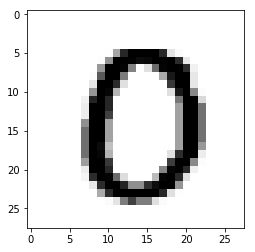

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
x = mnist.train.images[10]
x = x.reshape((28, 28))
plt.imshow(x, cmap=cm.binary)
plt.show()
#plt.imshow(mnist.train.images[1].reshape((height, width, channels)))
#plt.show()

In [7]:
type(mnist.train)

tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet

In [38]:
n_epochs = 100
batch_size = 100
prev_val = 0
stopping_criterion = 0
thr = 15
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size=batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
        print('epoch: {}, training accuracy: {}, validation accuracy: {}'.format(epoch, acc_train, acc_val))
        if acc_val < prev_val * (1 + thr / 100):
            stopping_criterion += 1
            if stopping_criterion >= 3:
                print('Early stopping invoked!')
                break
        #prev_val = acc_val
        saver_path = saver.save(sess, '/tmp/mnist_with_cnn3.ckpt')

epoch: 0, training accuracy: 0.9900000095367432, validation accuracy: 0.9846000075340271
epoch: 1, training accuracy: 0.9800000190734863, validation accuracy: 0.9846000075340271
epoch: 2, training accuracy: 1.0, validation accuracy: 0.9887999892234802
epoch: 3, training accuracy: 0.9900000095367432, validation accuracy: 0.9854000210762024
epoch: 4, training accuracy: 1.0, validation accuracy: 0.993399977684021
epoch: 5, training accuracy: 1.0, validation accuracy: 0.9905999898910522
epoch: 6, training accuracy: 1.0, validation accuracy: 0.9905999898910522
epoch: 7, training accuracy: 1.0, validation accuracy: 0.991599977016449
epoch: 8, training accuracy: 1.0, validation accuracy: 0.9922000169754028
epoch: 9, training accuracy: 1.0, validation accuracy: 0.9937999844551086
epoch: 10, training accuracy: 1.0, validation accuracy: 0.9926000237464905
epoch: 11, training accuracy: 1.0, validation accuracy: 0.9929999709129333
epoch: 12, training accuracy: 1.0, validation accuracy: 0.992600023

In [39]:
with tf.Session() as sess:
    saver.restore(sess, '/tmp/mnist_with_cnn3.ckpt')
    Z = logits.eval(feed_dict= {X: mnist.test.images})
    y_pred = np.argmax(Z, axis=1)
    print(np.mean(y_pred == mnist.test.labels).astype(np.float32))

INFO:tensorflow:Restoring parameters from /tmp/mnist_with_cnn3.ckpt
0.9947
